## Scraper code to extract reports of NAICS id: 237120
- NAICS 237120 corresponds to Construction in Oil & Gas accidents
- This code downloads the accident reports for 5 years data from 2013 to 2017.
- The final data will have three fields - the accident date, report id and report text.
- Each report will be appended to a pandas dataframe and finally exported to a csv file

In [2]:
#import libraries
from bs4 import BeautifulSoup 
import requests
import pandas as pd
import lxml

In [2]:
# add url to crawl
home_page = "https://www.osha.gov/pls/imis/AccidentSearch.search?p_logger=1&acc_description=&acc_Abstract=&acc_keyword=&sic=&naics=237120&Office=All&officetype=All&endmonth=01&endday=01&endyear=2013&startmonth=12&startday=31&startyear=2017&InspNr="

In [110]:
# fetch content from url
page_response = requests.get(home_page, timeout = 5)

#parse html
page_content = BeautifulSoup(page_response.content, "lxml")

In [1]:
# View content 
print(page_content.prettify())

<br/>

The above html content represents this webpage. We will call it our home page as we begin to scrape data from this url.

There are four points of interest here, which are highlighted in the image below:
- **Report ID**
- **Event Date**
- **Summary Nr**
- **Next Page**

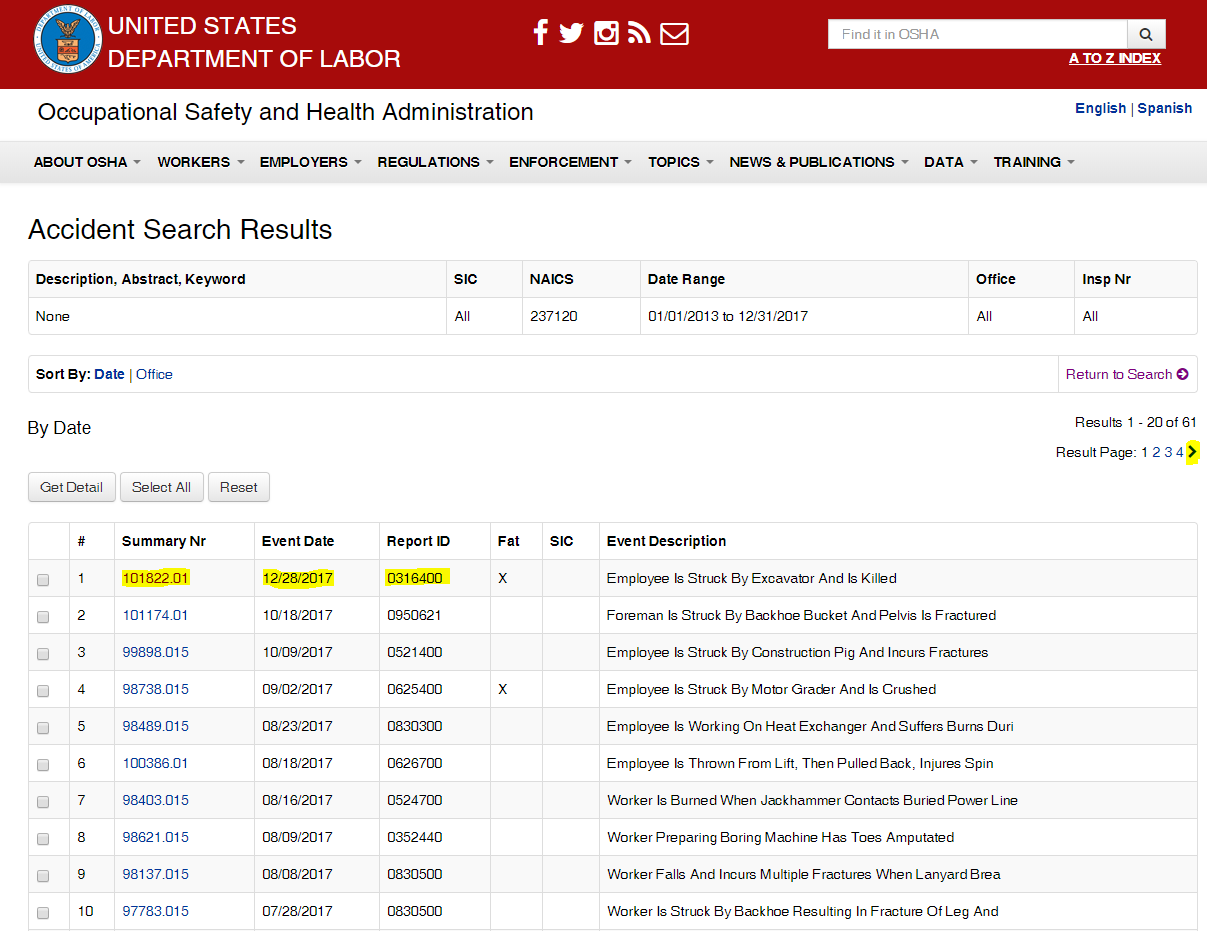

___
- We will begin with the first list item and extract the **Event Date** and **Report ID**. 
- Then we select the link in the **Summary Nr**, go to the new webpage to extract the report text. 
- Come back to iterate to the next item in the list until the end of the list items in this page.
- Select the link to the **Next Page** and repeat the same process until there is no **Next Page** link

In [109]:
# lets first create empty lists for all fields
event_date = []
report_id = []
summary = []
url_header = "https://www.osha.gov/pls/imis/"   #to open summary reports

In [111]:
# select the table containing Summary Nr, Event Date and Report ID
records = (page_content.find("div", id = ("wrapper"))
           .find("div", id = "maincontain", class_ = "container")
           .find_all("table", class_ = ("table table-bordered table-striped"))[1])

# print(records)  # lets view the table
# records is an object of bs4 class and of the type Tag
# Tags have a lot of attributes and methods which help to extract data

In [112]:
rcd_rows = records.find_all('tr')[1:]
for tr in rcd_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    event_date.append(row[3])    # copy date into list
    report_id.append(row[4])    # copy report_id into list
    # navigate to summary url
    rpt_url = url_header + str(tr.a.get('href'))
    rqst = requests.get(rpt_url, timeout=5)
    soup = BeautifulSoup(rqst.content, "lxml")
    smr = (soup.find("div", id = "maincontain", class_ = "container")
        .find("table", class_ = ("tablei_100 table-borderedi_100 table-striped")))
    smr_rows = smr.find_all('tr')[1:]
    for r in smr_rows:
        if r.td:
            if r.td.attrs['colspan'] == '8':
                summary.append(r.td.text.strip())
                break


We have obtained the data for the first page. Now we will select the **Next Page** link and iterate our process until the end of all pages.

In [115]:
nxt_page = (page_content
            .find("div", id = "maincontain", class_ = "container")
            .find_all('div', class_="text-right")[1]
            .find('a', title="Next Page"))

nxtpg_url = url_header + str(nxt_page.get('href'))

In [116]:
while(nxt_page != None):
    page_response = requests.get(nxtpg_url, timeout = 5)
    page_content = BeautifulSoup(page_response.content, "lxml")
    
    records = (page_content.find("div", id = ("wrapper"))
               .find("div", id = "maincontain", class_ = "container")
               .find_all("table", class_ = ("table table-bordered table-striped"))[1])
    rcd_rows = records.find_all('tr')[1:]
    for tr in rcd_rows:
        td = tr.find_all('td')
        row = [i.text for i in td]
        event_date.append(row[3])    # copy date into list
        report_id.append(row[4])    # copy report_id into list
        # navigate to summary url
        rpt_url = url_header + str(tr.a.get('href'))
        rqst = requests.get(rpt_url, timeout=5)
        soup = BeautifulSoup(rqst.content, "lxml")
        smr = (soup.find("div", id = "maincontain", class_ = "container")
            .find("table", class_ = ("tablei_100 table-borderedi_100 table-striped")))
        smr_rows = smr.find_all('tr')[1:]
        for r in smr_rows:
            if r.td:
                if r.td.attrs['colspan'] == '8':
                    summary.append(r.td.text.strip())
                    break
    
    nxt_page = (page_content
            .find("div", id = "maincontain", class_ = "container")
            .find_all('div', class_="text-right")[1]
            .find('a', title="Next Page"))
    if nxt_page != None: 
        nxtpg_url = url_header + str(nxt_page.get('href'))

### Reports collected
We have successfully obtained all accident reports for the years 2013 to 2017. Now, we will convert the lists into a dataframe and export as a csv file.

In [122]:
# Create pandas dataframe
acc_rpts = pd.DataFrame({"Event_Date" : event_date, 
                         "Report_ID" : report_id, 
                         "Summary" : summary})

In [124]:
acc_rpts.head()  # view head of dataframe

,Event_Date,Report_ID,Summary
0,12/28/2017,0316400,"At 1:00 p.m. on December 28, 2017, an employee..."
1,10/18/2017,0950621,"At 1:14 p.m. on October 18, 2017, Employee #1 ..."
2,10/09/2017,0521400,"At 10:00 a.m. on October 9, 2017, Employee #1,..."
3,09/02/2017,0625400,"At 4:30 a.m. on September 2, 2017, an employee..."
4,08/23/2017,0830300,"At 2:30 p.m. on August 23, 2017, an employee w..."


In [125]:
# export to CSV file
acc_rpts.to_csv('naics_237120_data.csv', sep=',', encoding='utf-8', index = False)

### Files saved
The data is now saved to a csv file. The data for other NAICS formats is also downloaded in this similar way (check for the jupyter notebooks with respective naics format filename)